**0. Importing dependencies**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import scipy.stats as scis
from sklearn.pipeline import Pipeline, FunctionTransformer


**1. Loading and understanding data**

In [3]:
df = pd.read_csv(os.path.join('data', 'Customer-Churn-Records.csv'))

In [5]:
df.shape

(10000, 18)

In [244]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [6]:
#Dropping Unwanted columns ('RowNumber', 'CustomerId','Surname') for modelling 
df.drop(columns=['RowNumber', 'CustomerId','Surname'], inplace=True)

In [7]:
df.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456


In [9]:
print(df.columns)

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Complain', 'Satisfaction Score', 'Card Type',
       'Point Earned'],
      dtype='object')


In [12]:
#Printing unique values in all columns excpet continuous numeric columns

numerical_features_list = ["CreditScore", "Age", "Balance", "EstimatedSalary", "Point Earned"]

for col in df.columns:
  if col not in numerical_features_list:
    print(col, df[col].unique())
    print("-"*50)


Geography ['France' 'Spain' 'Germany']
--------------------------------------------------
Gender ['Female' 'Male']
--------------------------------------------------
Tenure [ 2  1  8  7  4  6  3 10  5  9  0]
--------------------------------------------------
NumOfProducts [1 3 2 4]
--------------------------------------------------
HasCrCard [1 0]
--------------------------------------------------
IsActiveMember [1 0]
--------------------------------------------------
Exited [1 0]
--------------------------------------------------
Complain [1 0]
--------------------------------------------------
Satisfaction Score [2 3 5 4 1]
--------------------------------------------------
Card Type ['DIAMOND' 'GOLD' 'SILVER' 'PLATINUM']
--------------------------------------------------


In [13]:
print(df.isnull().sum())

CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64


In [14]:
#class distribution of the target column: 'Exited'
print(df['Exited'].value_counts())

Exited
0    7962
1    2038
Name: count, dtype: int64


**Insights:**
1. 'RowNumber', 'CustomerId' and 'Surname' columns are dropped as they are unwanted for modelling.
2. No missing values in the dataset
3. Class imbalance identified in the target: 'Exited'

**2.Exploratory Data Analysis (EDA)**

In [15]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


**Numerical Feature Analysis**

In [24]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Complain', 'Satisfaction Score', 'Card Type',
       'Point Earned'],
      dtype='object')

In [25]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


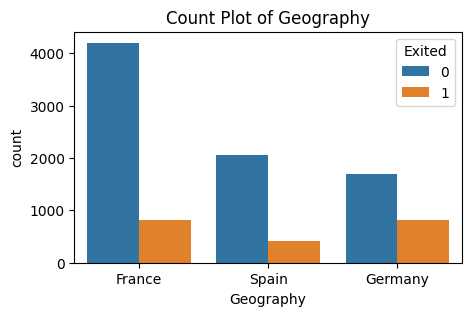

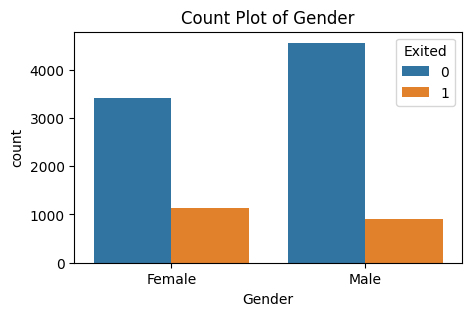

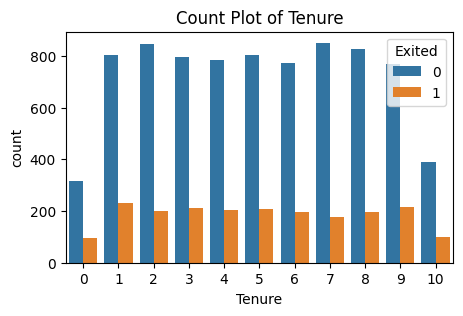

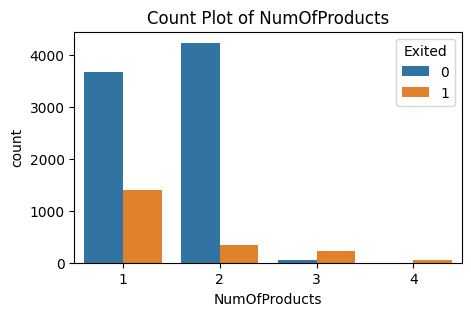

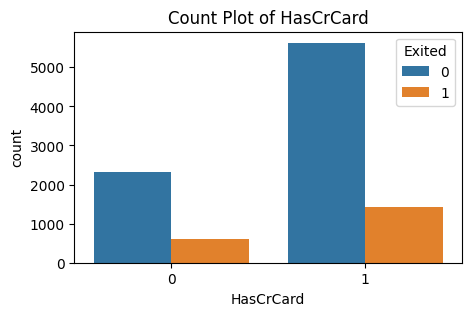

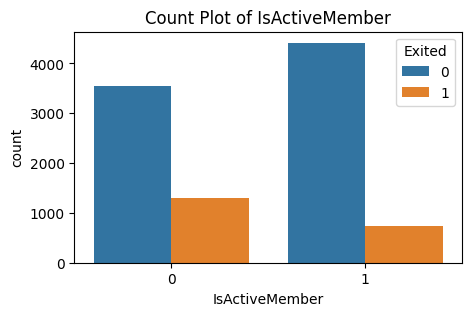

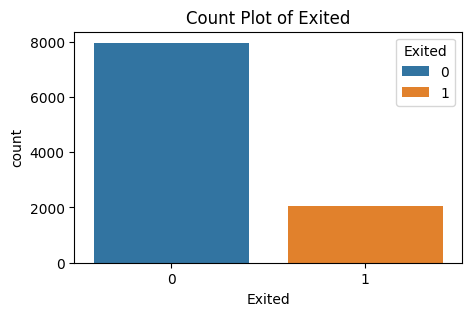

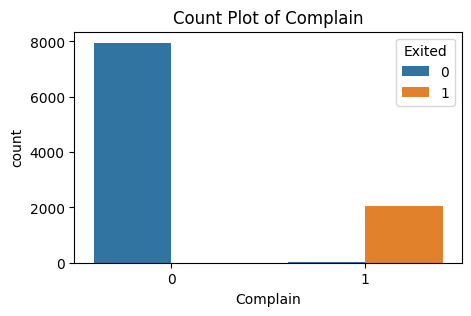

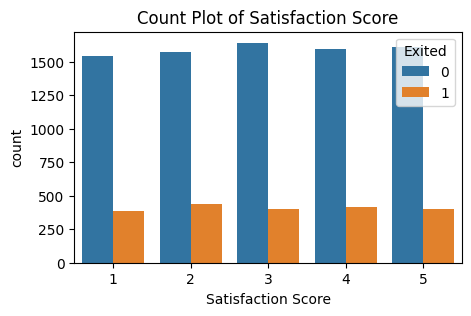

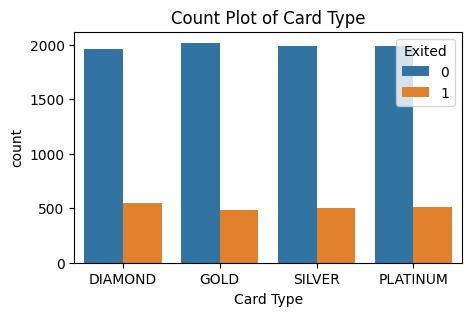

In [83]:
#Barplots for discrete numerical columns
dis_num_object_cols = ['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember','Exited','Complain',
                       'Satisfaction Score', 'Card Type']
for col in dis_num_object_cols:
  plt.figure(figsize=(5, 3))
  sns.countplot(x=df[col], hue=df['Exited'])
  plt.title(f"Count Plot of {col}")
  plt.show()

Clearly shows class imbalance of target class. Need to be fixed.

In [44]:
# Investigating the continuous features only
con_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Point Earned']
df[numerical_features_list].describe()


,CreditScore,Age,Balance,EstimatedSalary,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,76485.889288,100090.239881,606.515100
std,96.653299,10.487806,62397.405202,57510.492818,225.924839
min,350.000000,18.000000,0.000000,11.580000,119.000000
25%,584.000000,32.000000,0.000000,51002.110000,410.000000
50%,652.000000,37.000000,97198.540000,100193.915000,605.000000
75%,718.000000,44.000000,127644.240000,149388.247500,801.000000
max,850.000000,92.000000,250898.090000,199992.480000,1000.000000


note that the minimum and the first quartile for Balance feature are zeros. Further analysis required.

In [ ]:
#Distribution plots for continuous numerical columns
def plot_histogram(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.histplot(df[column_name], kde=True)
  plt.title(f"Distribution of {column_name}")

  # calculate the mean and median values for the columns
  col_mean = df[column_name].mean()
  col_median = df[column_name].median()

  # add vertical lines for mean and median
  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend()

  plt.show()

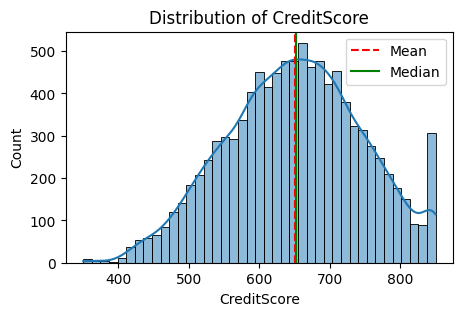

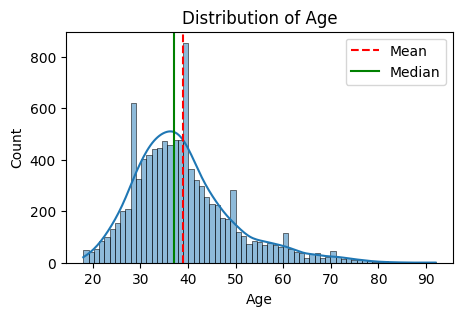

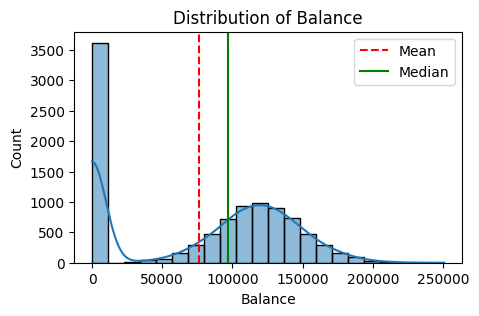

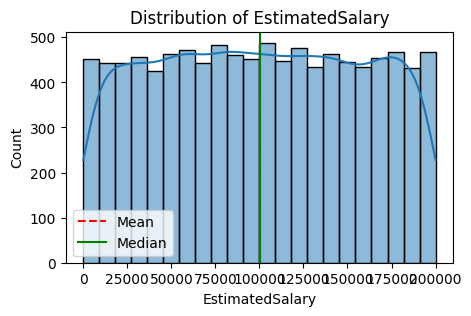

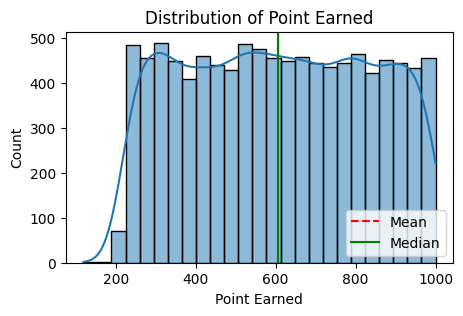

In [45]:
for col in con_features:
    plot_histogram(df, col)

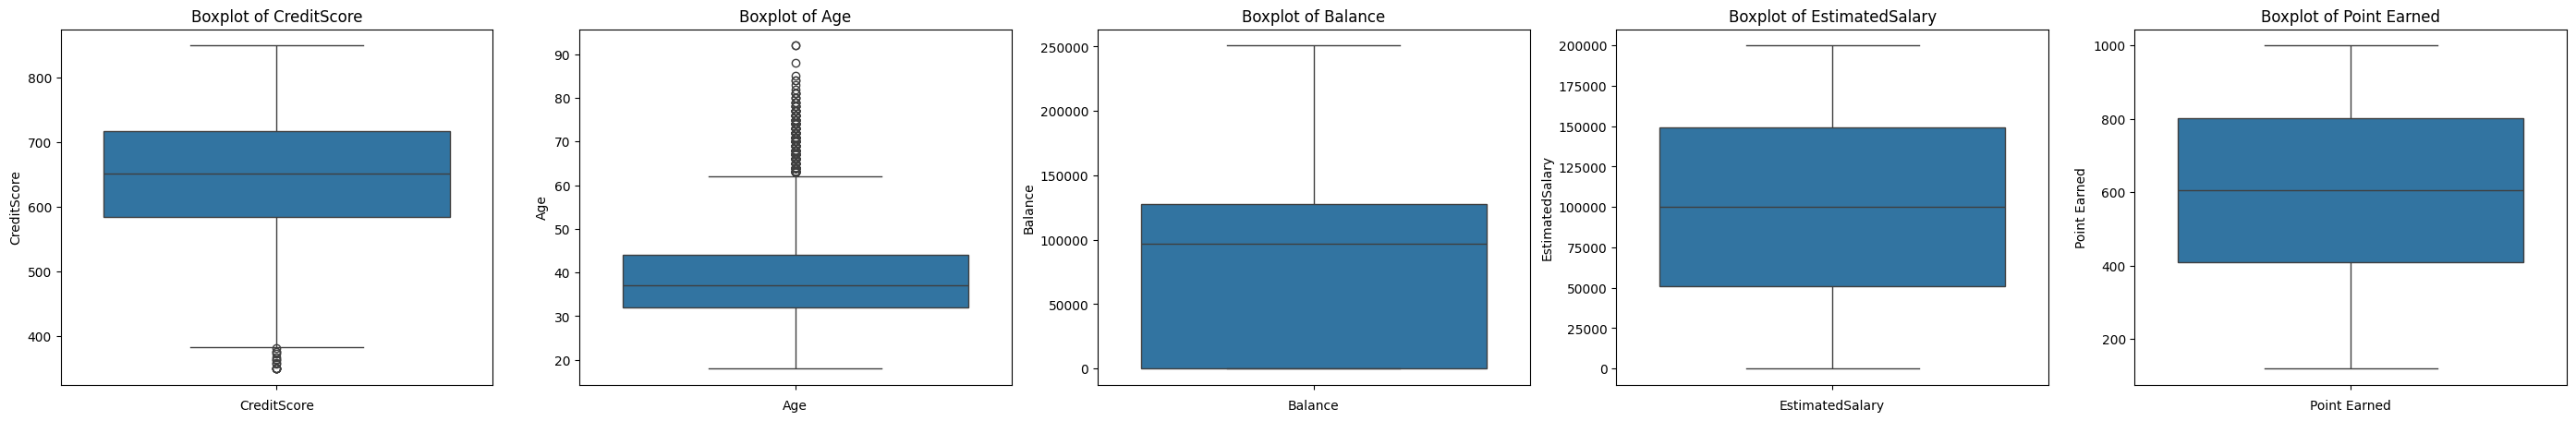

In [73]:
#Visual check for outliers in continuous features

fig, axs = plt.subplots(1, len(con_features), figsize=(35,5), sharex=False, sharey=False, )
for i, feature in enumerate(con_features):
     sns.boxplot(df[feature], ax=axs[i])
     axs[i].set_title(f'Boxplot of {feature}')
     axs[i].set_xlabel(feature)   


Both CreditScore and Age have data points that fall outside the whiskers. For CreditScore: below Q1-1.5*IQR. For Age: above Q3+ 1.5*IQR. Potential outliers.
EstimatedSalary and Point Earned are fairly uniform features and hence have no outliers.

In [84]:
#Testing normality for the continuous features (CreditScore, Age and Balance)

features = ['CreditScore', 'Age', 'Balance']

for col in features:
    stat, p = scis.shapiro(df[col])
    print(f'Shapiro-Wilk test for {col}: statistic={stat:.3f}, p-value={p:.5f}')


Shapiro-Wilk test for CreditScore: statistic=0.994, p-value=0.00000
Shapiro-Wilk test for Age: statistic=0.944, p-value=0.00000
Shapiro-Wilk test for Balance: statistic=0.846, p-value=0.00000


c:\Users\Akhila\Desktop\lancs\LUMS\Careers\MachineLearning\ChurnPrediction\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


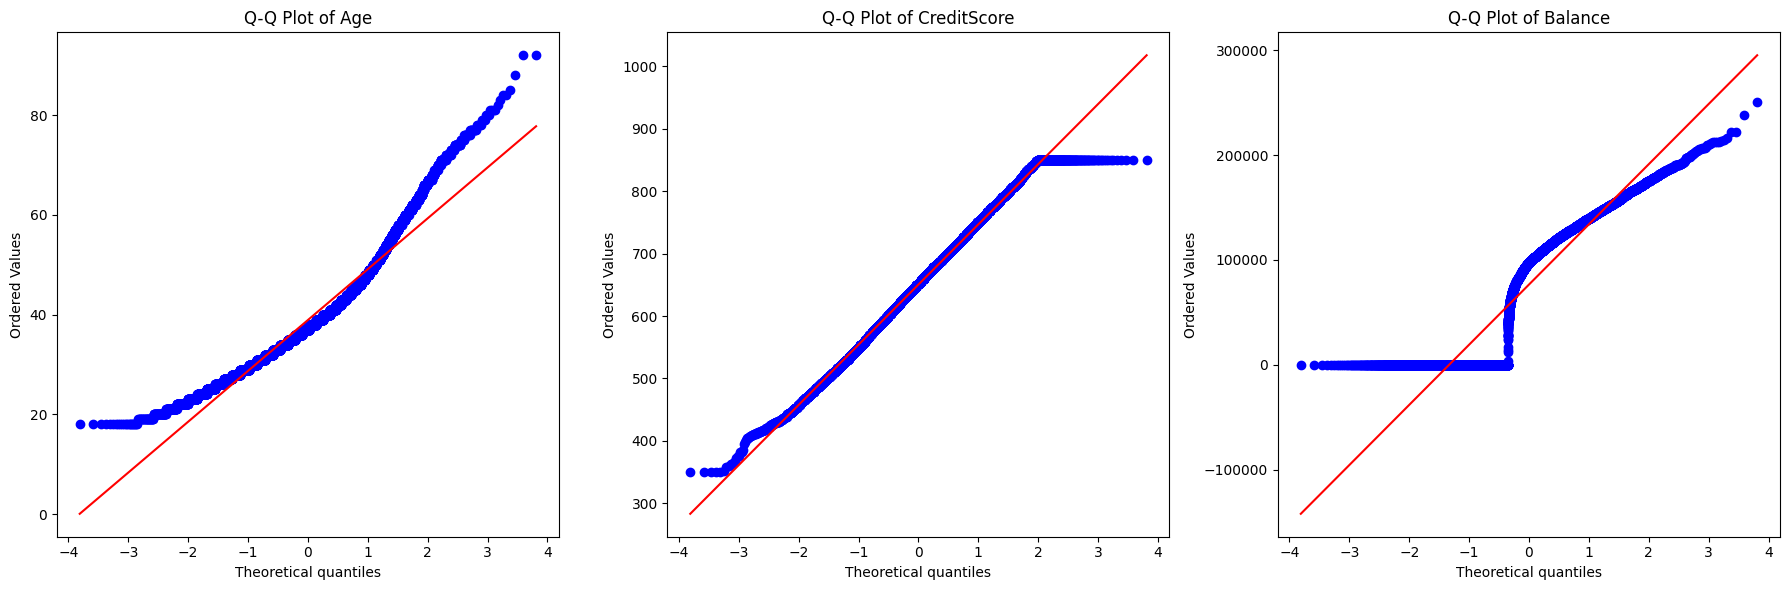

In [80]:
#Q-Q plots for normality testing

# we will check the normality for each of the 3 columns using q-q plot 
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

scis.probplot(df['Age'], dist="norm", plot=axs[0])
axs[0].set_title('Q-Q Plot of Age')

scis.probplot(df['CreditScore'], dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot of CreditScore')

scis.probplot(df['Balance'], dist="norm", plot=axs[2])
axs[2].set_title('Q-Q Plot of Balance')

plt.tight_layout()
plt.show()

Age and CreditScore are close normal distributions. CreditScore is slightly right skewed. Age has slightly negative skeweness. Column transformations are needed to fix skewness. Balance feature has a high left peak, need to be investigated.

<Axes: xlabel='Balance', ylabel='Count'>

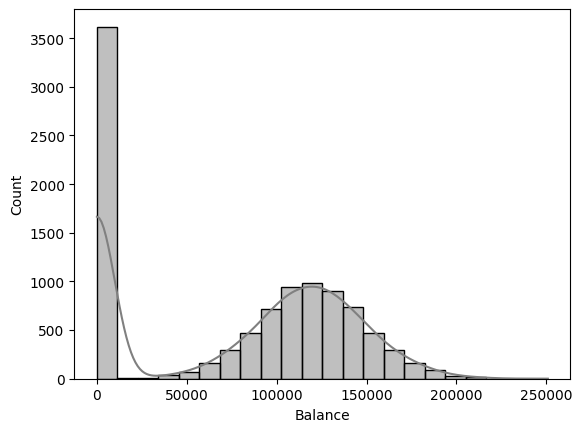

In [86]:
#Investigating Balance feature
sns.histplot(data=df, x='Balance', kde=True, color= 'grey')

Visually, Balance<50000 has a peak around 0. Balance over 50000 follows are close normal distribution. Let's slice the data around these points and visualise their influence on customers leaving the bank ('Exited').

In [96]:
#Slicing balance data into separate arrays to study the distribution in detail.    
divs = [0, 50000, 100000, 150000, 200000, 250000]
tot_customers = df.shape[0]

zero_balance_count = df[df['Balance'] == 0].shape[0]
zero_balance_perc = (zero_balance_count / tot_customers) * 100
print(f'Number of customers with a balance of 0: {zero_balance_count} ({zero_balance_perc:.2f}%)')

highest_balance_count = df[df['Balance'] > 250000].shape[0]
highest_balance_percentage = (highest_balance_count / tot_customers) * 100
print(f'Number of customers with a balance over 250000: {highest_balance_count} ({highest_balance_percentage:.2f}%)')

for i in range(len(divs) - 1):
    lower_div = divs[i]
    upper_div = divs[i + 1]
    
    count = df[(df['Balance'] > lower_div) & (df['Balance'] <= upper_div)].shape[0]
    percentage = (count / tot_customers) * 100
    print(f'Number of customers within the range {lower_div} and {upper_div}: {count} ({percentage:.2f}%)')



Number of customers with a balance of 0: 3617 (36.17%)
Number of customers with a balance over 250000: 1 (0.01%)
Number of customers within the range 0 and 50000: 75 (0.75%)
Number of customers within the range 50000 and 100000: 1509 (15.09%)
Number of customers within the range 100000 and 150000: 3830 (38.30%)
Number of customers within the range 150000 and 200000: 935 (9.35%)
Number of customers within the range 200000 and 250000: 33 (0.33%)


In [123]:
zero_bal_count = df[df['Balance']==0].groupby('Exited').Balance.count()
low_bal_count = df[(df['Balance']<=50000)&(df['Balance']>0)].groupby('Exited').Balance.count()
high_bal_count = df[df['Balance']>50000].groupby('Exited').Balance.count()

overall = df.groupby('Exited').Balance.count()

print(f'Overall customers not exited are {round(overall[0]/df.shape[0] * 100,3)}% and exited are {round(overall[1]/df.shape[0] * 100,3)}%')

print(f'Count of customers not exited the bank with balance = 0: {zero_bal_count[0]} and {round(zero_bal_count[0]/(zero_bal_count[0]+zero_bal_count[1]) *100, 3) } % of zero balance customers' )
print(f'Count of customers exited the bank with balance = 0: {zero_bal_count[1]} and {round(zero_bal_count[1]/(zero_bal_count[0]+zero_bal_count[1]) *100,3)} % of zero balance customers' )

print(f'Count of customers not exited the bank with balance between 0 and 50000 (low balance): {low_bal_count[0]} and {round(low_bal_count[0]/(low_bal_count[0]+low_bal_count[1]) *100, 3) } % of low balance customers' )
print(f'Count of customers exited the bank with balance between 0 and 50000 (low balance): {low_bal_count[1]} and {round(low_bal_count[1]/(low_bal_count[0]+low_bal_count[1]) *100,3)} % of low balance customers' )

print(f'Count of customers not exited the bank with balance  > 50000 (high balance): {high_bal_count[0]} and {round(high_bal_count[0]/(high_bal_count[0]+high_bal_count[1]) *100, 3) } % of high balance customers' )
print(f'Count of customers exited the bank with balance > 50000 (high balance): {high_bal_count[1]} and {round(high_bal_count[1]/(high_bal_count[0]+high_bal_count[1]) *100,3)} % of high balance customers' )


Overall customers not exited are 79.62% and exited are 20.38%
Count of customers not exited the bank with balance = 0: 3117 and 86.176 % of zero balance customers
Count of customers exited the bank with balance = 0: 500 and 13.824 % of zero balance customers
Count of customers not exited the bank with balance between 0 and 50000 (low balance): 49 and 65.333 % of low balance customers
Count of customers exited the bank with balance between 0 and 50000 (low balance): 26 and 34.667 % of low balance customers
Count of customers not exited the bank with balance  > 50000 (high balance): 4796 and 76.03 % of high balance customers
Count of customers exited the bank with balance > 50000 (high balance): 1512 and 23.97 % of high balance customers


Considering imbalance in the dataset for target class (customers exited or not), slicing Balance feature as above into zero balance, low balance and high balance groups classified the exited customers as 13.8%, 34.6% and 23.9% respectively in each group, which is fairly decent classification of 'Balance' feature. The different percentages of exited customers in the three groups suggest that the "Balance" feature helps distinguish between customers who exited and those who didn’t making 'Balance' an informative Feature.

In [132]:
d = df['Balance'].apply(lambda x: 'Bal_Zero' if x==0 else ('Bal_low_0_50k' if 0<x<=50000 else 'Bal_high_50k+'))
d.tail(10)

9990    Bal_low_0_50k
9991    Bal_high_50k+
9992         Bal_Zero
9993    Bal_high_50k+
9994         Bal_Zero
9995         Bal_Zero
9996    Bal_high_50k+
9997         Bal_Zero
9998    Bal_high_50k+
9999    Bal_high_50k+
Name: Balance, dtype: object

In [133]:
df['Balance_Category'] = df['Balance'].apply(lambda x: 'Bal_Zero' if x==0 else ('Bal_low_0_50k' if 0<x<=50000 else 'Bal_high_50k+'))

<Figure size 500x300 with 0 Axes>

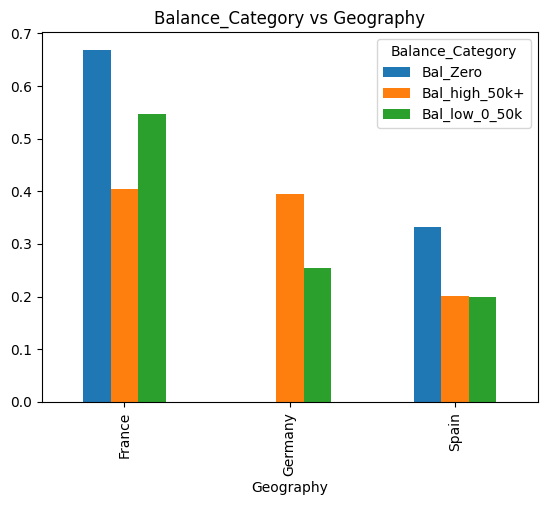

<Figure size 500x300 with 0 Axes>

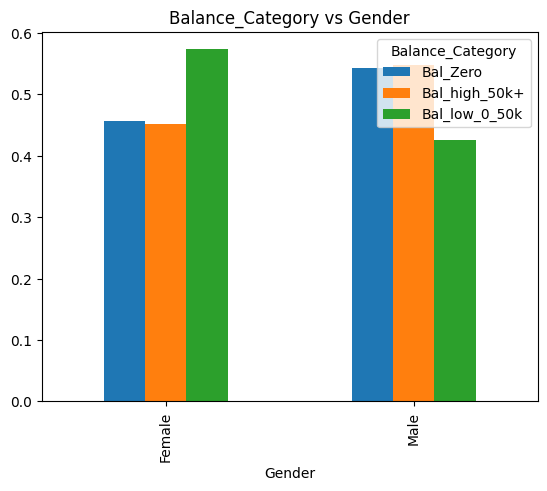

<Figure size 500x300 with 0 Axes>

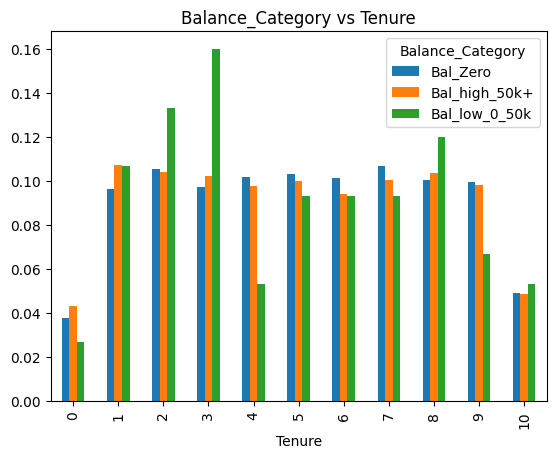

<Figure size 500x300 with 0 Axes>

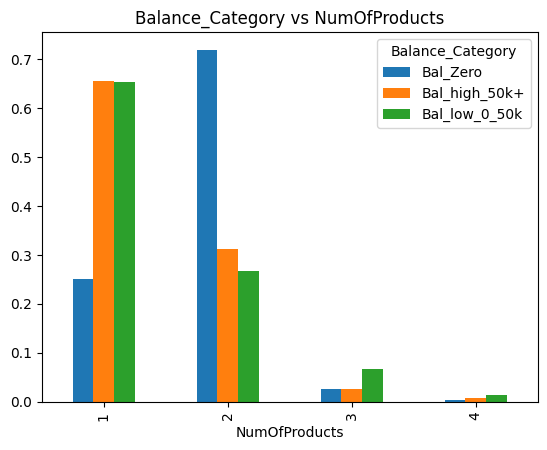

<Figure size 500x300 with 0 Axes>

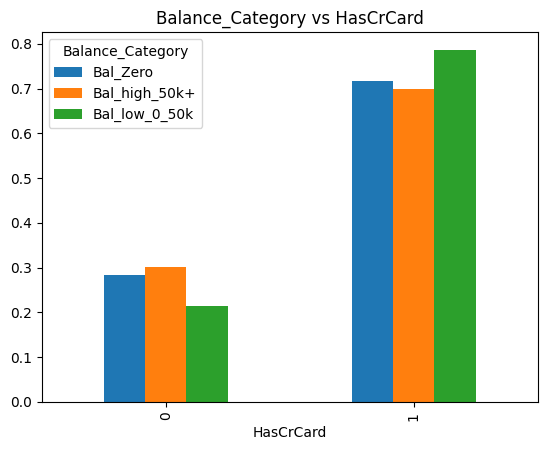

<Figure size 500x300 with 0 Axes>

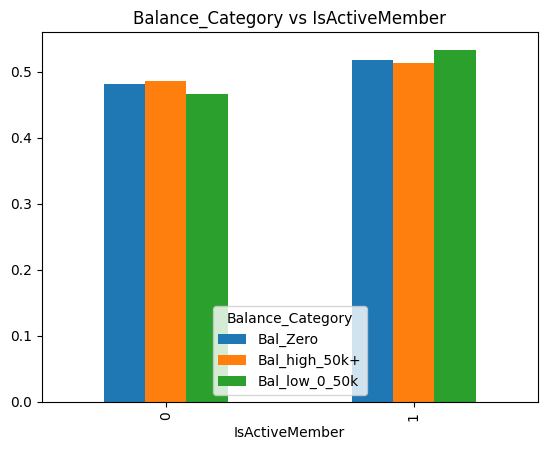

<Figure size 500x300 with 0 Axes>

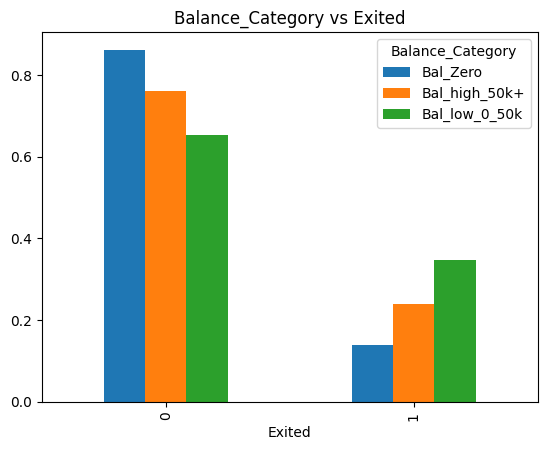

<Figure size 500x300 with 0 Axes>

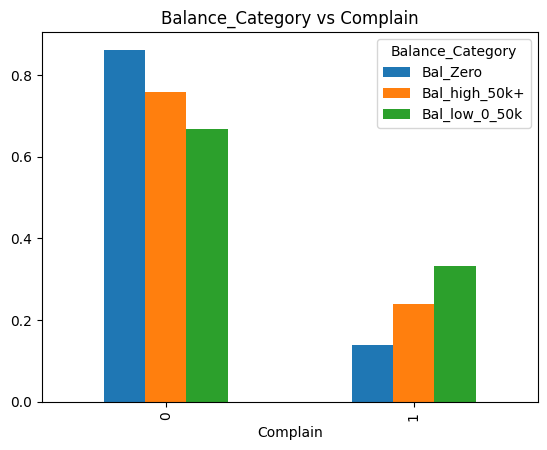

<Figure size 500x300 with 0 Axes>

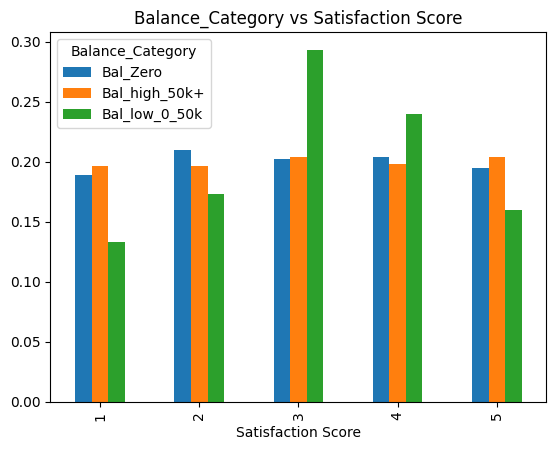

<Figure size 500x300 with 0 Axes>

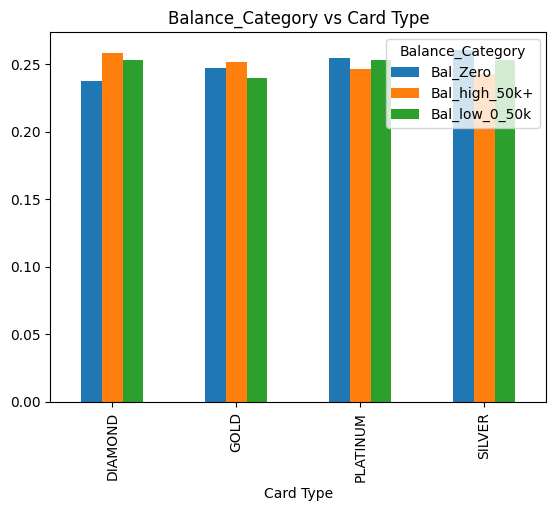

In [184]:
#Understanding discrete numerical and category columns with respect to Balance_Category
dis_num_object_cols = ['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember','Exited','Complain',
                       'Satisfaction Score', 'Card Type']

#df.groupby('Balance_Category')['Geography'].value_counts(normalize=True).unstack(level=0).plot.bar()
for col in dis_num_object_cols:
  plt.figure(figsize=(5, 3))
  df.groupby('Balance_Category')[col].value_counts(normalize=True).unstack(level=0).plot.bar()
  plt.title(f"Balance_Category vs {col}")
  plt.show()

From the above plots, new the Balance_Category column displays distinction between categories of the majority of numerical discrete and categorigal columns, making it an informative feature.

In [176]:
#Testing boxcox and log transformation on Age columns

df['Age_BoxCox'], param_age = scis.boxcox(df['Age'])
df['Age_logTrans'] = np.log(df['Age'])

print(f"skewness of Age after BoxCox Transformation: {df['Age_BoxCox'].skew()} and parameter {param_age}")
print(f"skewness of Age after Log Transformation: {df['Age_logTrans'].skew()}")
print(f"skewness of Age before  Transformation: {df['Age'].skew()}")



skewness of Age after BoxCox Transformation: -0.002396709819571761 and parameter -0.22419844427386304
skewness of Age after Log Transformation: 0.182020112559587
skewness of Age before  Transformation: 1.0113202630234552


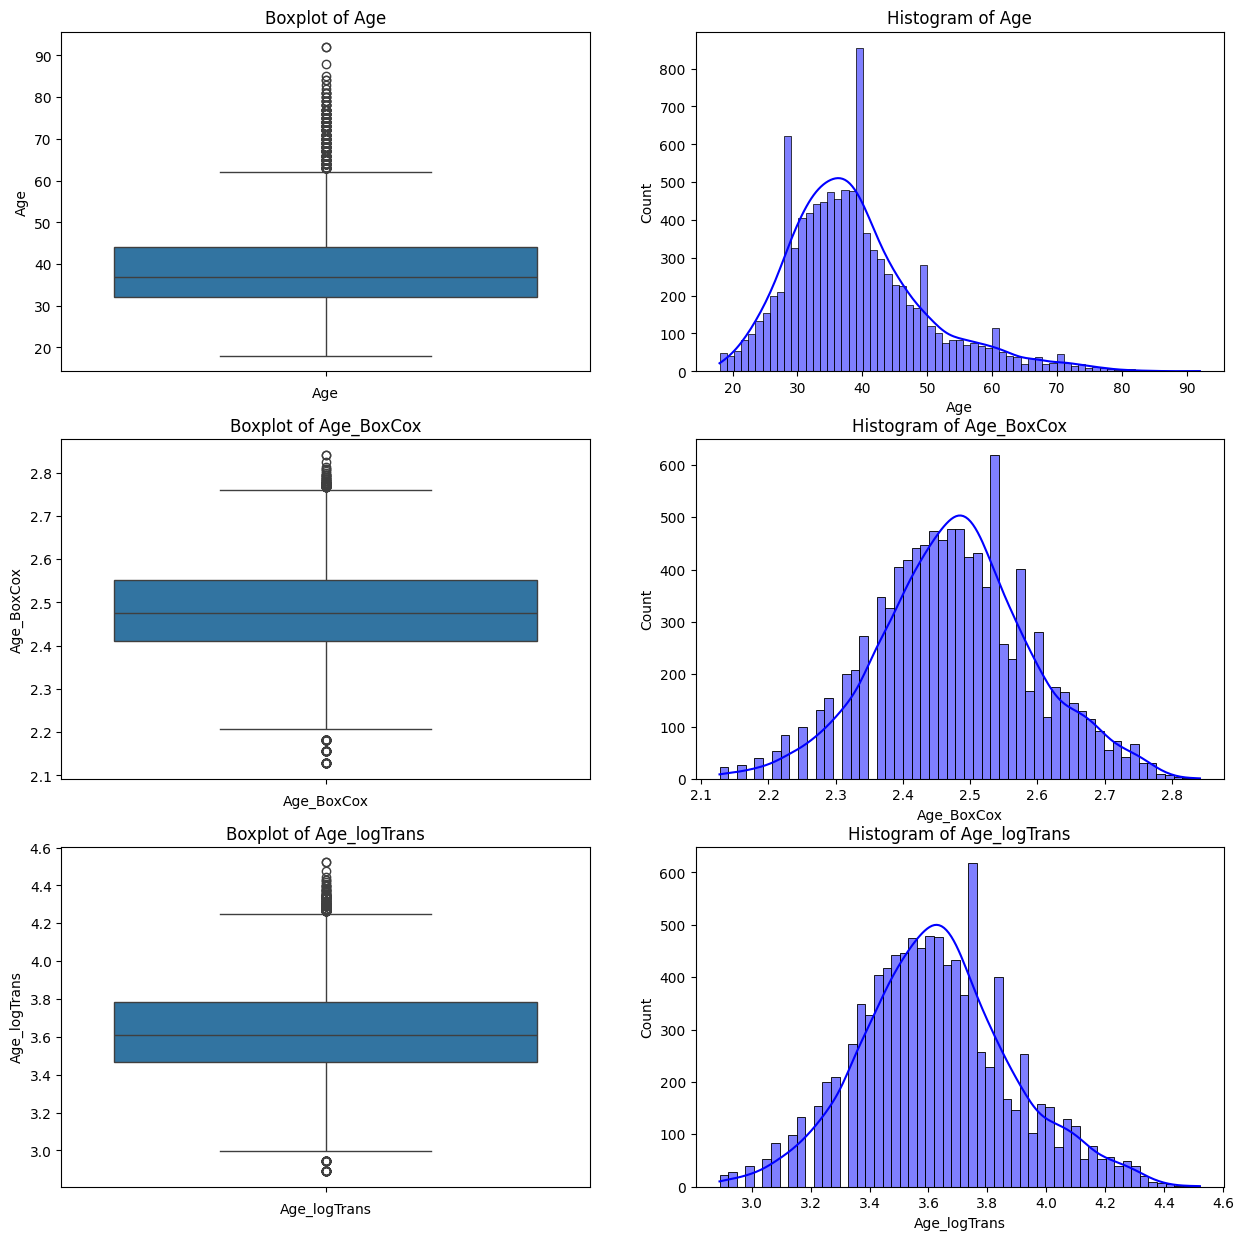

In [177]:
age_cols = ['Age','Age_BoxCox', 'Age_logTrans']


fig, axes = plt.subplots(len(age_cols), 2, figsize=(15, 5 * len(age_cols)), sharex=False, sharey=False)

for i, feature in enumerate(age_cols):
    sns.boxplot(df[feature], ax=axes[i, 0])
    axes[i, 0].set_title(f'Boxplot of {feature}')
    axes[i, 0].set_xlabel(feature)
    
    sns.histplot(df[feature], kde=True, color='blue', ax=axes[i, 1])
    axes[i, 1].set_title(f'Histogram of {feature}')
    axes[i, 1].set_xlabel(feature)


BoxCox transformation on Age significantly reduced skewness tranforming it fairly Gaussian.

**Correlation Heatmap for numeric columns**

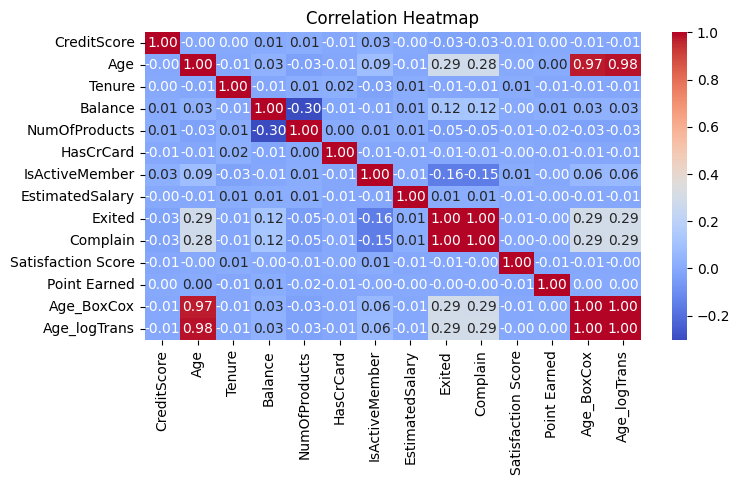

In [182]:
# correlation matrix - heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df[list(df.select_dtypes('number'))].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Complain and Exited are higly correlated (corr coeff =1). we exclude complain from the sample dataset.

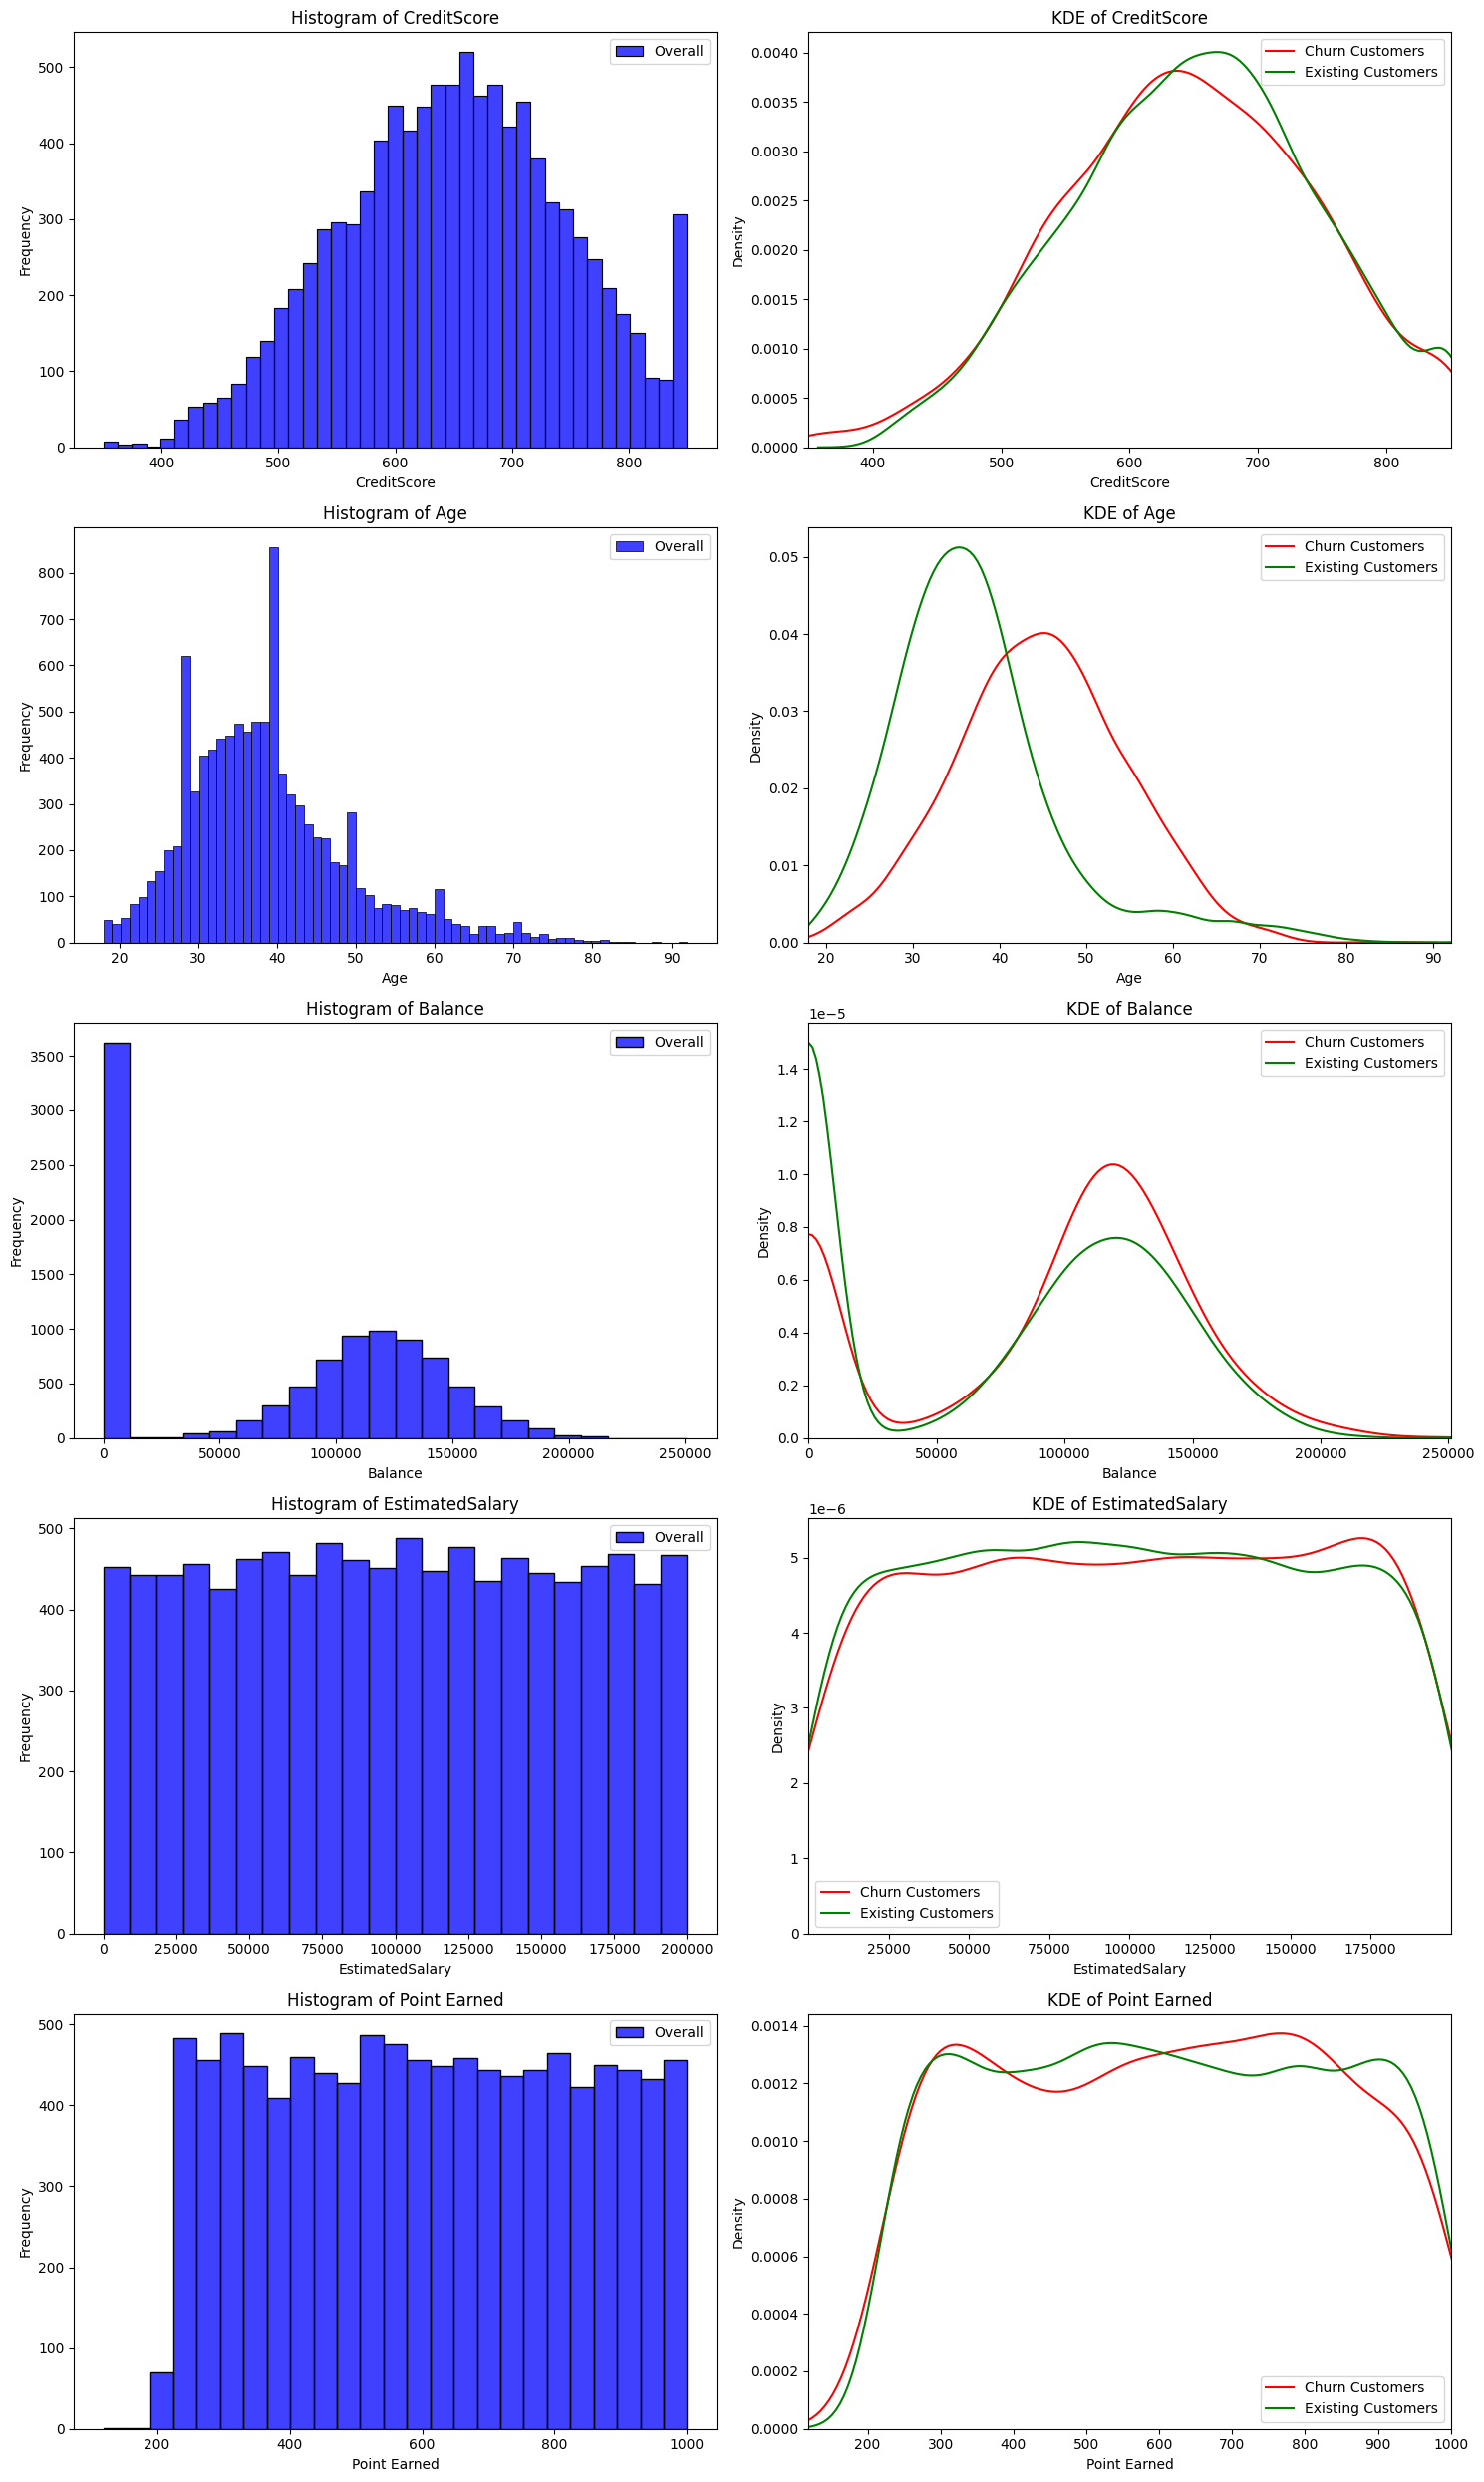

In [43]:
# investigating the continous features through plotting the histogrgram and KDE for both existing and churn customers
fig, axes = plt.subplots(len(numerical_features_list), 2, figsize=(15, 5 * len(numerical_features_list)), sharex=False, sharey=False)

for i, feature in enumerate(numerical_features_list):
    ax_hist = axes[i, 0]
    ax_kde = axes[i, 1]
    
    sns.histplot(df[feature], kde=False, color='blue', ax=ax_hist, label='Overall')
    
    ax_hist.set_title(f'Histogram of {feature}')
    ax_hist.set_xlabel(feature)
    ax_hist.set_ylabel('Frequency')
    ax_hist.legend()
    
    sns.kdeplot(df.loc[df['Exited'] == 1, feature], color='red', ax=ax_kde, label='Churn Customers')
    sns.kdeplot(df.loc[df['Exited'] == 0, feature], color='green', ax=ax_kde, label='Existing Customers')
    ax_kde.set_title(f'KDE of {feature}')
    ax_kde.set_xlabel(feature)
    ax_kde.set_ylabel('Density')
    ax_kde.legend()
    
    ax_kde.set_xlim(left=df[feature].min(), right=df[feature].max())

plt.tight_layout()
plt.show()

**4. Train Test Split**

In [4]:
X = df.drop(columns=['Exited'])
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

**5. Data Preprocessing**

Tranformations Required:
1. RowNumber, CustomerId and Surname has no effect on customer leaving the bank. (drop them while preprocessing)
2. Drop Complain column (high correlation eith Exited column).
3. Age - right skewed (boxcox transformation) and drop Age column.
4. Balance - out of 10000 customers in sample, 3617 customers (36.17%) have zero account balance. Bimodal distribution with large proportion of values concentrated around 0, and a fairly Gaussian distribution beyond that. Create a new Balance_Category column and drop Balance.
6. Satisfaction Score: covert to object. use onehotencoding as it has score values 1,2,3,4,5 categories.
7. Encode categorical columns: onehotencoding: Geography, Gender, Card Type, Balance_Category
8. Normalize numerical columns: CreditScore, Age_BoxCox, Tenure, NumOfProducts, OneYearBalance,EstimatedSalary, Point Earned
9. SMOTE



In [7]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
       'Satisfaction Score', 'Card Type', 'Point Earned'],
      dtype='object')

In [17]:

def balance_transform(X):
    """Convert balance to categories."""
    balance_category = X['Balance'].apply(lambda x: 'Bal_Zero' if x == 0 else ('Bal_low_0_50k' if 0 < x <= 50000 else 'Bal_high_50k+')).rename('Balance_Category')
    
    return pd.DataFrame(data = balance_category, columns=['Balance_Category'])

def satisfaction_score_transform(X):
    """ Convert Satisfaction Score into object column"""
    return pd.DataFrame(data = X['Satisfaction Score'].astype('object'))

def drop_columns(X):
    """Drops specified columns from a DataFrame."""
    columns_to_drop = ['RowNumber', 'CustomerId', 'Complain', 'Surname']  # Specify the columns to drop
   
    return X.drop(columns=columns_to_drop)

age_pipeline = Pipeline(steps=[
    ('boxcox', BoxCoxTransformer()),
    ('standsca', StandardScaler())
])
balance_pipeline = Pipeline(steps=[
    ('bal_category', FunctionTransformer(balance_transform, validate=False)),
    ('onehot', OneHotEncoder(sparse_output=False))
])
satisfaction_pipeline = Pipeline(steps=[
    ('satisfaction_transform', FunctionTransformer(satisfaction_score_transform, validate=False)),
    ('onehot', OneHotEncoder(sparse_output=False))
])
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False))
])

num_norm_pipeline = Pipeline(steps=[
    ('stan_scaler', StandardScaler())
])

num_uni_pipeline = Pipeline(steps=[
    ('minmax_scaler', MinMaxScaler())
])

# Step 3: Combine transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('age', age_pipeline, ['Age']),
        ('balance', balance_pipeline, ['Balance']),
        ('satisfaction', satisfaction_pipeline, ['Satisfaction Score']),
        ('categorical', cat_pipeline, ['Geography', 'Gender', 'Card Type']),
        ('numerical_uni', num_uni_pipeline, ['Tenure', 'EstimatedSalary', 'Point Earned']),
        ('numerical_norm', num_norm_pipeline, ['CreditScore', 'NumOfProducts'])

    ], verbose_feature_names_out=False, remainder= "passthrough"
)
preprocessor.set_output(transform='pandas')


# Step 4: Create the full pipeline including column dropping
full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),            # Apply transformations
    ('drop_columns', FunctionTransformer(drop_columns, validate=False))  # Drop original columns
])



In [18]:
# Apply the pipeline
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

In [19]:
X_train_transformed.describe()
X_test_transformed.describe()

,Age,Balance_Category_Bal_Zero,Balance_Category_Bal_high_50k+,Balance_Category_Bal_low_0_50k,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5,Geography_France,...,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Tenure,EstimatedSalary,Point Earned,CreditScore,NumOfProducts,HasCrCard,IsActiveMember
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.0000,2000.000000,2000.00000,2000.00000,2000.00000,2000.000000,...,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.003315,0.365500,0.629000,0.005500,0.1855,0.201000,0.21000,0.21000,0.19350,0.505500,...,0.232000,0.249000,0.25500,0.502900,0.511857,0.555250,-0.006203,-0.000429,0.697500,0.509000
std,0.989667,0.481691,0.483193,0.073976,0.3888,0.400848,0.40741,0.40741,0.39514,0.500095,...,0.422215,0.432542,0.43597,0.289972,0.289001,0.255812,0.998082,0.994355,0.459455,0.500044
min,-3.106060,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.00000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000423,0.098751,-3.109407,-0.910597,0.000000,0.000000
25%,-0.606516,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.00000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.200000,0.269109,0.335982,-0.689303,-0.910597,0.000000,0.000000
50%,0.071912,0.000000,1.000000,0.000000,0.0000,0.000000,0.00000,0.00000,0.00000,1.000000,...,0.000000,0.000000,0.00000,0.500000,0.515405,0.552781,0.003633,-0.910597,1.000000,1.000000
75%,0.627719,1.000000,1.000000,0.000000,0.0000,0.000000,0.00000,0.00000,0.00000,1.000000,...,0.000000,0.000000,1.00000,0.700000,0.763779,0.776674,0.675884,0.806701,1.000000,1.000000
max,2.883971,1.000000,1.000000,1.000000,1.0000,1.000000,1.00000,1.00000,1.00000,1.000000,...,1.000000,1.000000,1.00000,1.000000,0.999244,1.000000,2.061755,4.241298,1.000000,1.000000


In [ ]:

def preprocessing(df):

    df.drop(columns=['RowNumber', 'CustomerId', 'Complain', 'Surname'], inplace=True)
    df['Age_BoxCox'], param_age = scis.boxcox(df['Age'])
    df.drop(columns='Age', inplace=True)
    df['Balance_Category'] = df['Balance'].apply(lambda x: 'Bal_Zero' if x==0 else ('Bal_low_0_50k' if 0<x<=50000 else 'Bal_high_50k+'))
    df.drop(columns='Balance', inplace=True)
    df['Satisfaction Score'] = df['Satisfaction Score'].astype('object')

    cat_cols = ['Geography', 'Gender', 'Card Type', 'Balance_Category', 'Satisfaction Score']
    num_norm_cols = ['CreditScore', 'Age_BoxCox', 'NumOfProducts']
    num_uni_cols = ['Tenure', 'EstimatedSalary', 'Point Earned']

    column_transform = ColumnTransformer(transformers=[
                ('categoric_transform', OneHotEncoder(sparse_output=False,), cat_cols),
                ('numeric_uni_transform', MinMaxScaler(), num_uni_cols),
                ('numeric_norm_transform', StandardScaler(), num_norm_cols)
                ], verbose_feature_names_out=False)
    column_transform.set_output(transform='pandas')
    df_scaled = column_transform.fit_transform(df)

    return df_scaled






In [256]:
X_train_scaled = preprocessing(X_train)

In [258]:
X_train_scaled.columns

Index(['Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male', 'Card Type_DIAMOND', 'Card Type_GOLD',
       'Card Type_PLATINUM', 'Card Type_SILVER', 'Balance_Category_Bal_Zero',
       'Balance_Category_Bal_high_50k+', 'Balance_Category_Bal_low_0_50k',
       'Satisfaction Score_1', 'Satisfaction Score_2', 'Satisfaction Score_3',
       'Satisfaction Score_4', 'Satisfaction Score_5', 'Tenure',
       'EstimatedSalary', 'Point Earned', 'CreditScore', 'Age_BoxCox',
       'NumOfProducts'],
      dtype='object')

In [259]:
# 2. Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [260]:
X_train_smote.shape

(12740, 23)

In [266]:
y_train.value_counts()

Exited
0    6370
1    1630
Name: count, dtype: int64

In [265]:
y_train_smote.value_counts()

Exited
0    6370
1    6370
Name: count, dtype: int64

**5. Model Training**

In [267]:
#fitting 4 models as base ones(Benchmarks)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Initialize the models
logistic_model = LogisticRegression(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)
svm_model = SVC(probability=True, random_state=42)  
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Fit the models on the training data
logistic_model.fit(X_train_smote, y_train_smote)
random_forest_model.fit(X_train_smote, y_train_smote)
svm_model.fit(X_train_smote, y_train_smote)
xgb_model.fit(X_train_smote, y_train_smote)



c:\Users\Akhila\Desktop\lancs\LUMS\Careers\MachineLearning\ChurnPrediction\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:45:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [268]:
X_test_transformed = preprocessing(X_test)

In [270]:
# Predict on the test set
logistic_preds = logistic_model.predict(X_test_transformed)
random_forest_preds = random_forest_model.predict(X_test_transformed)
svm_preds = svm_model.predict(X_test_transformed)
xgb_preds = xgb_model.predict(X_test_transformed)

In [271]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, average_precision_score

# Evaluate Logistic Regression
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, logistic_preds))
print("Classification Report:\n", classification_report(y_test, logistic_preds))

# Evaluate Random Forest
print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, random_forest_preds))
print("Classification Report:\n", classification_report(y_test, random_forest_preds))


# Evaluate Support Vector Machines
print("Support Vector Machines Performance:")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print("Classification Report:\n", classification_report(y_test, svm_preds))

# Evaluate XGBoost
print("\nXGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print("Classification Report:\n", classification_report(y_test, xgb_preds))

Logistic Regression Performance:
Accuracy: 0.6905
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78      1592
           1       0.37      0.71      0.48       408

    accuracy                           0.69      2000
   macro avg       0.63      0.70      0.63      2000
weighted avg       0.79      0.69      0.72      2000


Random Forest Performance:
Accuracy: 0.828
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      1592
           1       0.58      0.55      0.57       408

    accuracy                           0.83      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.82      0.83      0.83      2000

Support Vector Machines Performance:
Accuracy: 0.7805
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.80      0.85      1592
           1     

Average Precision for Logistic Regression model is 0.41
Average Precision for Random Forest model is 0.59
Average Precision for Support Vector Machine model is 0.59
Average Precision for XGBoost model is 0.61


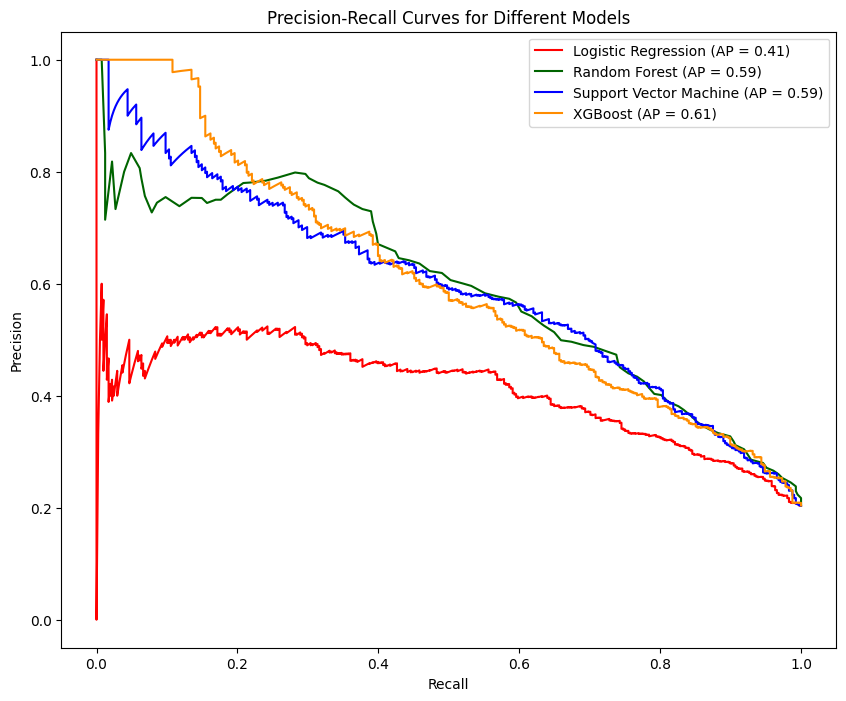

In [272]:
# Calculate Precision-Recall curve and Average Precision for each model
logistic_probs = logistic_model.predict_proba(X_test_transformed)[:, 1] 
logistic_precision, logistic_recall, _ = precision_recall_curve(y_test, logistic_probs)
logistic_ap = average_precision_score(y_test, logistic_probs, average= 'weighted')
print(f'Average Precision for Logistic Regression model is {logistic_ap:.2f}')

random_forest_probs = random_forest_model.predict_proba(X_test_transformed)[:, 1]  
random_forest_precision, random_forest_recall, _ = precision_recall_curve(y_test, random_forest_probs)
random_forest_ap = average_precision_score(y_test, random_forest_probs, average= 'weighted')
print(f'Average Precision for Random Forest model is {random_forest_ap:.2f}')

svm_probs = svm_model.predict_proba(X_test_transformed)[:, 1] 
svm_precision, svm_recall, _ = precision_recall_curve(y_test, svm_probs)
svm_ap = average_precision_score(y_test, svm_probs, average= 'weighted')
print(f'Average Precision for Support Vector Machine model is {svm_ap:.2f}')

xgb_probs = xgb_model.predict_proba(X_test_transformed)[:, 1]
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
xgb_ap = average_precision_score(y_test, xgb_probs, average= 'weighted')
print(f'Average Precision for XGBoost model is {xgb_ap:.2f}')

# Plot all Precision-Recall curves in a single figure
plt.figure(figsize=(10, 8))

plt.plot(logistic_recall, logistic_precision, label=f'Logistic Regression (AP = {logistic_ap:.2f})', color='red')
plt.plot(random_forest_recall, random_forest_precision, label=f'Random Forest (AP = {random_forest_ap:.2f})', color='darkgreen')
plt.plot(svm_recall, svm_precision, label=f'Support Vector Machine (AP = {svm_ap:.2f})', color='blue')
plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AP = {xgb_ap:.2f})', color='darkorange')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Different Models')
plt.legend()
plt.show()

In [277]:
# As the results indicate that SVM, RF and XGB give the better results compared to lr, we will cintinue fine tuning them 
from sklearn.model_selection import GridSearchCV
#Define SVM model and parameters for GridSearch
svm_model = SVC(probability=True, random_state=42)  
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
    
}

# GridSearchCV for SVM
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_params, cv=5, n_jobs=-1, verbose=2, scoring='average_precision')
svm_grid_search.fit(X_train_smote, y_train_smote)

# Best XGBoost Model
svm_grid_model = svm_grid_search.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [278]:
best_svm_grid_preds = svm_grid_model.predict(X_test_transformed)
# Evaluate best Support Vector Machines
print("Support Vector Machines Performance:")
print("Accuracy:", accuracy_score(y_test, best_svm_grid_preds))
print("Classification Report:\n", classification_report(y_test, best_svm_grid_preds))


Support Vector Machines Performance:
Accuracy: 0.794
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87      1592
           1       0.50      0.60      0.54       408

    accuracy                           0.79      2000
   macro avg       0.69      0.72      0.71      2000
weighted avg       0.81      0.79      0.80      2000



In [274]:
# Define Random Forest model and parameters for GridSearch
rf_model = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30]
    
}

# GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_params, cv=5, n_jobs=-1, verbose=2, scoring='average_precision')
rf_grid_search.fit(X_train_smote, y_train_smote)

# Best Random Forest Model
best_rf_model = rf_grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [276]:
best_rf_preds = best_rf_model.predict(X_test_transformed)
# Evaluate best Random Forest
print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, best_rf_preds))
print("Classification Report:\n", classification_report(y_test, best_rf_preds))


Random Forest Performance:
Accuracy: 0.8295
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      1592
           1       0.59      0.56      0.57       408

    accuracy                           0.83      2000
   macro avg       0.74      0.73      0.73      2000
weighted avg       0.83      0.83      0.83      2000



In [279]:
# Define XGBoost model and parameters for GridSearch
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', objective= 'binary:logistic')
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 8],
    'learning_rate': [0.05, 0.1, 0.3]
}

# GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=5, n_jobs=-1, verbose=2, scoring='average_precision')
xgb_grid_search.fit(X_train_smote, y_train_smote)

# Best XGBoost Model
best_xgb_model = xgb_grid_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\Akhila\Desktop\lancs\LUMS\Careers\MachineLearning\ChurnPrediction\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [02:52:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [280]:
# best model Predict on the test set

best_rf_preds = best_rf_model.predict(X_test_transformed)
best_svm_preds = svm_grid_model.predict(X_test_transformed)
best_xgb_preds = best_xgb_model.predict(X_test_transformed)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, average_precision_score


# Evaluate best Random Forest
print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, best_rf_preds))
print("Classification Report:\n", classification_report(y_test, best_rf_preds))


# Evaluate best Support Vector Machines
print("Support Vector Machines Performance:")
print("Accuracy:", accuracy_score(y_test, best_svm_preds))
print("Classification Report:\n", classification_report(y_test, best_svm_preds))

# Evaluate best XGBoost
print("\nXGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, best_xgb_preds))
print("Classification Report:\n", classification_report(y_test, best_xgb_preds))


Random Forest Performance:
Accuracy: 0.8295
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      1592
           1       0.59      0.56      0.57       408

    accuracy                           0.83      2000
   macro avg       0.74      0.73      0.73      2000
weighted avg       0.83      0.83      0.83      2000

Support Vector Machines Performance:
Accuracy: 0.794
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87      1592
           1       0.50      0.60      0.54       408

    accuracy                           0.79      2000
   macro avg       0.69      0.72      0.71      2000
weighted avg       0.81      0.79      0.80      2000


XGBoost Performance:
Accuracy: 0.8085
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.88      1592
           1       0.52     

**5. Model save**

In [282]:
# save the trained model as a pickle file
import pickle
model_data = {"model": best_rf_model, "features_names": X_train_smote.columns.tolist()}


with open(os.path.join("models","customer_churn_model.pkl"), "wb") as f:
  pickle.dump(model_data, f)

In [285]:
# load the saved model and the feature names

with open(os.path.join("models","customer_churn_model.pkl"), "rb") as f:
  model_data = pickle.load(f)

loaded_model = model_data["model"]
feature_names = model_data["features_names"]

In [286]:
print(loaded_model)

RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=300,
                       random_state=42)
